In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import models,layers

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=30

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "POTATO",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2022-12-28 12:07:06.579979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-28 12:07:06.580004: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-28 12:07:06.580024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divum-Latitude-7490): /proc/driver/nvidia/version does not exist
2022-12-28 12:07:06.580378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

2022-12-28 12:11:11.865958: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


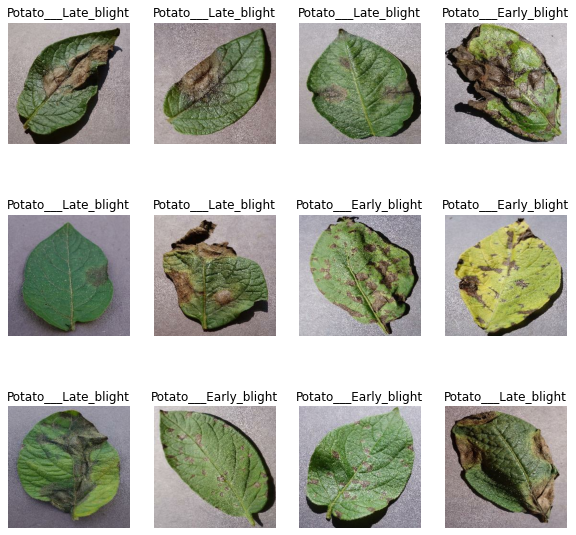

In [6]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

# SPLITTING THE DATA

In [7]:
len(dataset)

68

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
len(train_ds)


54

In [17]:
len(val_ds)


6

In [18]:
len(test_ds)


8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# MODEL BUILDING

In [22]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [24]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Applying Data Augmentation to Train Dataset

In [25]:
train_ds=train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

In [30]:
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

In [31]:
model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 60, 60, 64)         

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [34]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30


2022-12-28 12:36:09.028810: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-12-28 12:36:09.061758: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-12-28 12:36:09.088994: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-12-28 12:36:09.113180: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


54/54 [==============================] - 112s 2s/step - loss: 0.8832 - accuracy: 0.5162 - val_loss: 0.7079 - val_accuracy: 0.6875
Epoch 2/30
54/54 [==============================] - 108s 2s/step - loss: 0.6591 - accuracy: 0.6875 - val_loss: 0.4907 - val_accuracy: 0.7448
Epoch 3/30
54/54 [==============================] - 105s 2s/step - loss: 0.3975 - accuracy: 0.8241 - val_loss: 0.4054 - val_accuracy: 0.8333
Epoch 4/30
54/54 [==============================] - 117s 2s/step - loss: 0.2694 - accuracy: 0.8987 - val_loss: 0.3136 - val_accuracy: 0.8646
Epoch 5/30
54/54 [==============================] - 119s 2s/step - loss: 0.1806 - accuracy: 0.9277 - val_loss: 0.3365 - val_accuracy: 0.8646
Epoch 6/30
54/54 [==============================] - 106s 2s/step - loss: 0.1426 - accuracy: 0.9444 - val_loss: 0.2085 - val_accuracy: 0.9062
Epoch 7/30
54/54 [==============================] - 104s 2s/step - loss: 0.1446 - accuracy: 0.9462 - val_loss: 0.1371 - val_accuracy: 0.9531
Epoch 8/30
54/54 [======

In [35]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 463ms/step - loss: 0.0448 - accuracy: 0.9922


In [36]:
scores

[0.04475562274456024, 0.9921875]

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

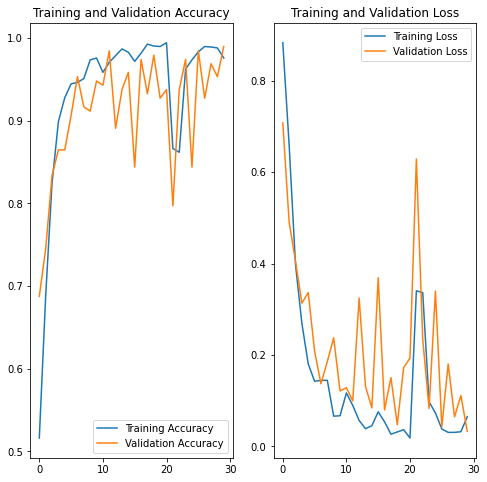

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label :  Potato___Early_blight
1/1 [==============================] - 0s 469ms/step
predicted label :  Potato___Early_blight


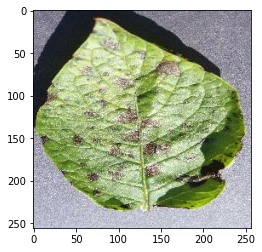

In [56]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label : ",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [57]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 40ms/step


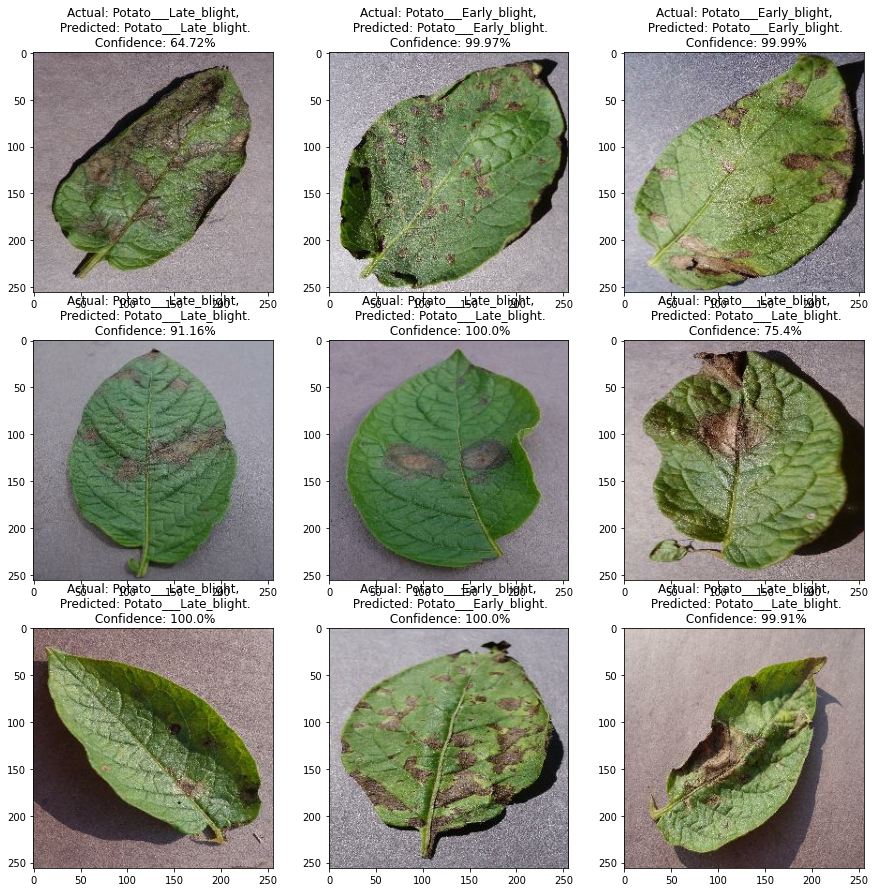

In [60]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

In [62]:
model.save("potatoes.h5")

In [66]:
from tensorflow import keras
loaded_model = keras.models.load_model('potatoes.h5')

1/1 [==============================] - 0s 51ms/step


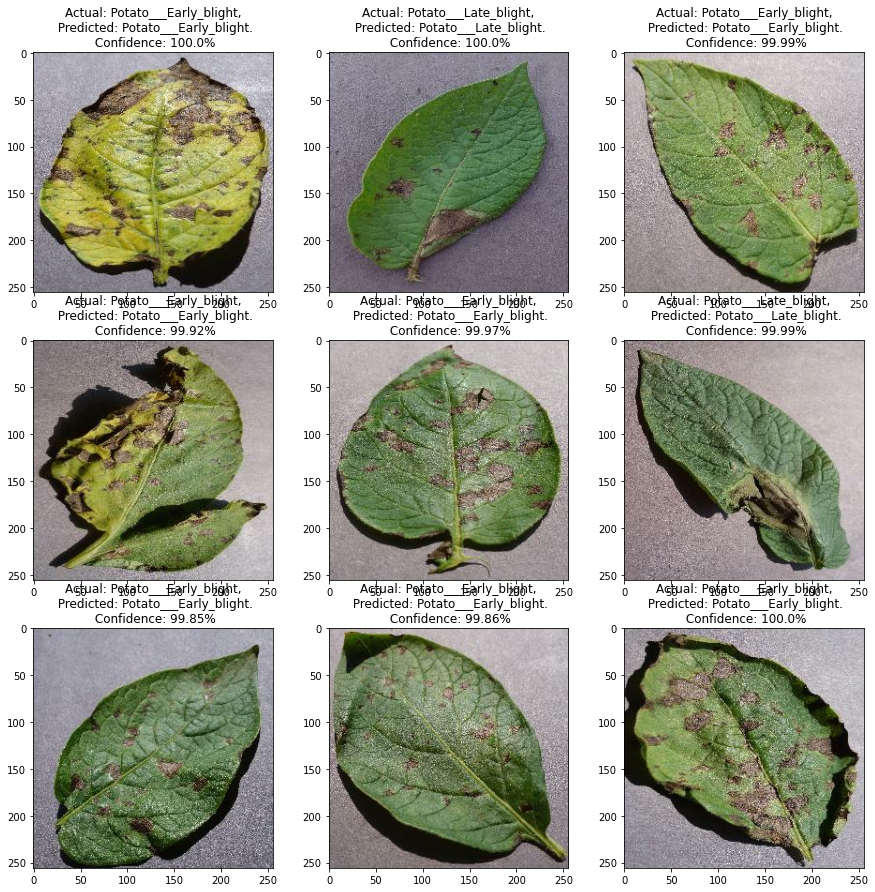

In [67]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(loaded_model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")